# CNN Tutorial with PyTorch on the MNIST Dataset

In this tutorial, we will build a Convolutional Neural Network (CNN) to classify handwritten digits from the MNIST dataset. We'll go through the following steps:

1. **Data Loading, Processing, and Augmentation**
2. **Data Exploration**
3. **Model Building**
4. **Model Training**
5. **Model Evaluation**

## 1. Data Loading, Processing, and Augmentation

The MNIST dataset consists of 28x28 pixel grayscale images of handwritten digits (0-9). We'll use PyTorch's `torchvision` to load and preprocess the data. We will also apply some augmentations to improve our model's robustness.

### Exercise

1. Import the necessary libraries.
2. Load the MNIST dataset using `torchvision.datasets`.
3. Apply normalization to the dataset.
4. Create data loaders for training and testing with appropriate batch sizes.
5. Experiment with different data augmentations like rotation, translation, and flipping.

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Definir a transformação
transform = transforms.ToTensor()

# Carregar o conjunto de dados
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

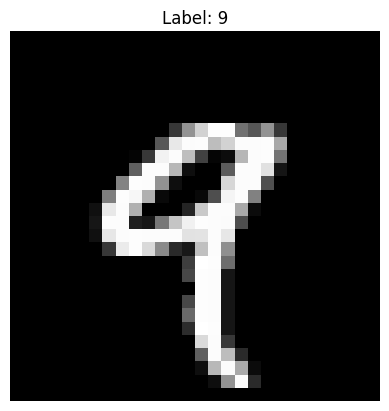

In [2]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# Obter uma imagem e seu rótulo
image, label = train_dataset[4]

# Converter para NumPy
image = image.numpy().squeeze()

# Exibir a imagem
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

In [3]:
# ..

## 2. Data Exploration

Before training our model, it's essential to explore the data. This helps us understand its distribution and visualize some examples.

### Exercise
1. Visualize a few images from the training dataset along with their labels.
2. Print the number of samples in the training and test datasets.

In [4]:
# ..

## 3. Model Building

Now, we'll define our CNN architecture. A typical CNN consists of convolutional layers, activation functions, pooling layers, and a fully connected output layer.

### Exercise
1. Define a CNN class inheriting from torch.nn.Module.
2. Include two convolutional layers, ReLU activations, max pooling, and a fully connected layer.

In [5]:
# ..

## 4. Model Training

We'll now define the training loop to optimize our model using the cross-entropy loss function and the Adam optimizer.

### Exercise
1. Define a function to train the model for a specified number of epochs.
2. Print the training loss after each epoch.

In [6]:
# ..

## 5. Model Evaluation

After training, we need to evaluate our model on the test dataset to understand its performance.

### Exercise
1. Define a function to evaluate the model's accuracy on the test set.
2. Print the accuracy.

In [7]:
# ..